**"Bayesian adaptive prior, is that you?": Comparing different approaches of mixed effects modeling**

For a while, I've wondered about the different approches for multilevel modeling, also known as mixed effects modeling. My initial understanding is with a Bayesian perspective since I learned about it from Statistical Rethinking. But when hearing others talk about "fixed effects", "varying effects", "random effects", and "mixed effects", I had trouble connecting my own understanding of the concept to theirs. Even more perplexing, I wasn't sure what the *source(s)* of the differences were:
- It it a frequentist vs. Bayesian thing?
- Is it a statistical package thing?
- Is it because there are five different definitions of "fixed and random effects", [infamously observed by Andrew Gelman](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and why he avoids using those terms?

I decided to take a deep dive to resolve my confusion, with much help from numerous sources. Please check out the [Acknowledgments and references](#Acknowledgementsa-and-references) section!

In this post, I'll be comparing an example of mixed effects modeling across statistical philosophies and across statistical languages. As a bonus, a meme awaits.

| method | approach  |  language | package |
| -- |-- | ------ | ----- |
| 1 | frequentist  |  R | `lme4` | 
| 2 | Bayesian  |  Python | `pymc` | 

Note that the default language in the code blocks is Python. A cell running R will have `%%R` designated at the top. A variable can be inputted (`-i`) or outputted (`-o`) on that same line if it is used between the two languages.

*Special thanks to Patrick Robotham for providing a lot of feedback.*

In [1]:
from aesara import tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
import xarray as xr

In [77]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)
az.rcParams["stats.hdi_prob"] = 0.95 

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [3]:
# Enable running of R code
%load_ext rpy2.ipython

In [4]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(lme4))
suppressMessages(library(arm))
suppressMessages(library(merTools))

# Create synthetic `cafe` dataset

The dataset I am using is created from a scenario described in Statistical Rethinking.

Here are a few more details of the dataset from Dr. McElreath's book:
> Begin by defining the population of cafés that the robot might visit. This means we’ll define the average wait time in the morning and the afternoon, as well as the correlation between them. These numbers are sufficient to define the average properties of the cafés. Let’s define these properties, then we’ll sample cafés from them.

Nearly all Python code is taken from the [Statistical Rethinking pymc repo](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) with some minor alterations.

In [5]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)  # covariance matrix

N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

Now simulate the observations.

In [151]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
df_cafes = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

To get a sense of the data structure we just created, let's take a look at the first and last 5 rows.

In [7]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,2.724888
1,0,1,1.951626
2,0,0,2.488389
3,0,1,1.188077
4,0,0,2.026425


In [8]:
df_cafes.tail()

,cafe,afternoon,wait
195,19,1,3.394933
196,19,0,4.544430
197,19,1,2.719524
198,19,0,3.379111
199,19,1,2.459750


Note that this dataset is balanced, meaning that each group (cafe) has the same number of observations. Mixed effects / multilevel models shine with unbalanced data where it can leverage partial pooling.

# Visualize data

Let's plot the raw data and see how the effect of afternoon influences wait time. Instead of plotting in order of the arbitrarily named cafes (0 to 19), I'll show in order of increasing average morning wait time so that we can appreciate the variability across the dataset.

In [212]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,2.644592
1,0,1,2.126485
2,0,0,2.596465
3,0,1,2.250297
4,0,0,3.310709


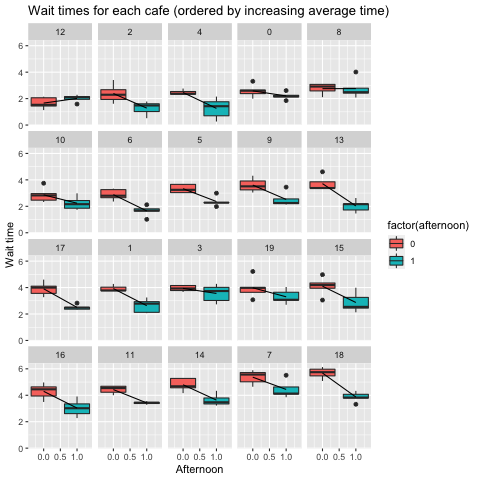

In [217]:
%%R -i df_cafes

# credit to TJ Mahr for a template of this code
xlab <- "Afternoon"
ylab <- "Wait time"
titlelab <- "Wait times for each cafe (ordered by increasing average time)"

# order by increasing average morning wait time (intercept only)
cafe_ordered_by_avgwaittime <- df_cafes %>%
              filter(afternoon==0) %>%
              group_by(cafe) %>%
              summarize(mean = mean(wait)) %>%
              arrange(mean)

# Turn the gear column from a numeric in a factor with a certain order
df_cafes$cafe <- factor(df_cafes$cafe, levels=cafe_ordered_by_avgwaittime$cafe)

ggplot(df_cafes) + 
  aes(x = afternoon, y = wait) + 
  geom_boxplot(aes(fill=factor(afternoon))) +
  stat_summary(fun.y="mean", geom="line") +
  facet_wrap("cafe") +
  labs(x = xlab, y = ylab, title=titlelab)

One pattern is that as we increase morning wait time (e.g. the intercept) the difference in wait time in the afternoon (the slope) gets bigger. In other words, when we simulated this dataset, we included a *co-variance* structure between the intercept and slope. When we develop an inferential model with this data, we want to be able to reveal this co-variance.

# Definitions of mixed effects modeling

## Equation set 1: both fixed and random effects terms in linear model

[Galecki and Burzykowski](https://link.springer.com/book/10.1007/978-1-4614-3900-4), [Wikipedia](https://en.wikipedia.org/wiki/Mixed_model), and [this page from UCLA](https://stats.oarc.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/) all describe a linear mixed model with an equation similar to equation 1 below.

*I rely heavily on the UCLA page since it is the one that helped me the most. In fact, if you don't care about how it connects to the Bayesian approach, stop reading this and check that out instead!*

In contrast to the Bayesian set of equations, the fixed effects and random effects are in the same equation here.

$$ \textbf{y} = \textbf{X} \boldsymbol{\beta} + \textbf{Z} \textbf{u} + \boldsymbol{\epsilon}  \tag{1}$$

The left side of the equation $\textbf{y}$ represents all of our observations (or the wait time in the cafe example). The $\boldsymbol{\beta}$ in the first term of the equation represents a vector of coefficients across the population of cafes. These are the fixed effects. The $\textbf{u}$ in the second term of equation 1 represents a matrix of coefficients for *each individual cafe*. These are the random effects. Both $\textbf{X}$ and $\textbf{Z}$ are the design matrix of covariates. Finally, there's a residual error term $\boldsymbol{\epsilon}$.

When relating this equation all back to the cafe dataset we just created, I needed to dig deeper to how terms represented an individual observation versus the group (cafe) level. Doing a dimensional analysis helped.

| Equation 1 variable | Dimensions  |  Effects type | Comment |
| -- |-- | ------ | ----- |
| $\textbf{y}$ | 200 x 1  |  n/a |  This vector represents the wait time for all 200 observations. I'll refer to this as $w_i$ later in equation 2. | 
| $\textbf{X}$ | 200 x 2  |  associated with fixed |  The first column of each observation is 1 since it is multiplied by the intercept term. The second column is $A$, which will be 0 or 1 for `afternoon`. | 
| $\boldsymbol{\beta}$ | 2 x 1 |  fixed | The two elements in the $\boldsymbol{\beta}$ (bold font beta) are what I'll refer to as the intercept $\alpha$ and the slope $\beta$ (unbolded beta) across all cafes in equation 2. | 
| $\textbf{Z}$ | 200 x (2x20)  |  associated with random |  The first 20 columns representing intercepts for each cafe and the second 20 for the covariate (`afternoon`). See visual below.  |
| $\textbf{u}$ | (2x20) x 1  |  random |  $\textbf{u}$ holds each of the 20 cafes' intercept $a_\text{cafe}$ and slope $b_\text{cafe}$. There's an implied correlation structure between them. |
| $\boldsymbol{\epsilon}$| 200 x 1  |  n/a |  Normally distributed residual error. |

To better understand what $\textbf{Z}$ looks like we can create an alternate representation of `df_cafes`. Each row of the matrix $\textbf{Z}$ is for an individual observation. The first 20 columns of a row are the 20 intercepts of a cafe (column 1 is cafe 1, column 2 is cafe 2, etc.) All of the first 20 columns will contain a 0 *except* for the column that represents the cafe that observation is associated with which will be a 1. The next 20 columns (columns 21-40) will represent `afternoon`. All of this second group of columns will be 0 *except* for the column that represents the cafe that observation is associated with *and* if the observation is associated with an afternon observation.

To be clear, the structure of `df_cafes`, where each row is an observation with the cafe, afternoon status, and wait time, is already in a form to be understood by the `lmer` and `pymc` packages. What I'm showing below is to help understand what the matrix $\textbf{Z}$ looks like in the above equations.

In [184]:
Z = np.zeros((200, 40))
for i in df_cafes.index:
    cafe = df_cafes.loc[i, 'cafe']
    afternoon = df_cafes.loc[i, 'afternoon']
    Z[i, cafe] = 1
    Z[i, 20+cafe] = afternoon

We can take a look at the first 12 rows of Z. The first 10 are for the first cafe and observations alternate morning and afternoon, hence what's displayed in column 20. I included the first two rows of the second cafe to show how the `1` moves over a row after the first 10 rows. I'll use `pandas` to better display the values.

In [208]:
pd.set_option('display.max_columns', 40)
(
    pd.DataFrame(Z[0:12, :])
    .astype(int)
    .style
    .highlight_max(axis=1, props='color:navy; background-color:yellow;')
    .highlight_min(axis=1, props='color:white; background-color:#3E0B51;')
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can visualize all of $\textbf{Z}$ here.

Text(0.5, 1.0, 'Visual representation of Z')

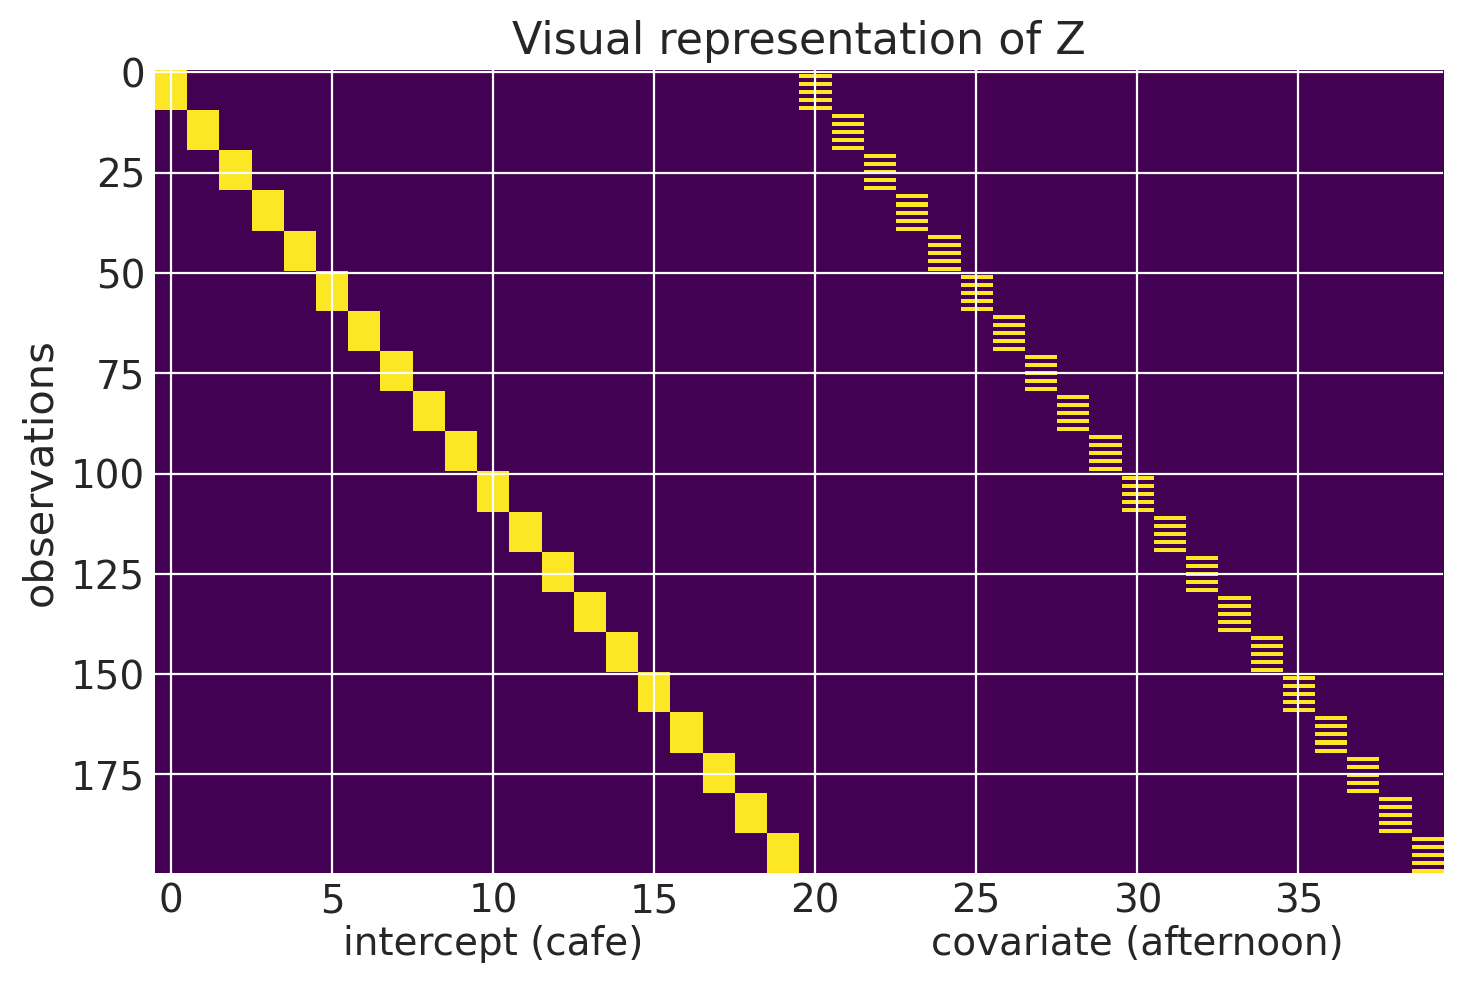

In [207]:
plt.imshow(Z, aspect='auto')
plt.text(10, 220, s='intercept (cafe)', ha='center', fontsize=14)
plt.text(30, 220, s='covariate (afternoon)', ha='center', fontsize=14)
plt.ylabel('observations')
plt.title('Visual representation of Z')

The vector in $\textbf{u}$ is really where the mixed effects model takes advantage of the covariance structure of the data. In our dataset, the first 20 elements of the vector represent the random intercepts of the cafes and the next 20 are the random slopes. A cafe's random effects can be thought of as an offset from the populations (the fixed effects). Accordingly, a random effect will be multivariate normally distributed, with mean 0 and a co-variance matrix S.

$$ \textbf{u} \sim \text{Normal}(0, \textbf{S}) \tag{2}$$ 
   
Remember that the $\textbf{u}$ is a (2x20) x 1 matrix, where each cafe's intercept $a_\text{cafe}$ and slope $b_\text{cafe}$ are contained. Therefore, we can also write this as.

$$ \textbf{u} = \begin{bmatrix} a_{\text{cafe}} \\ b_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix} , \textbf{S} \right)   \tag{3}$$ 

In other words, in Equation 1, both the random intercept and random slope are both expected to lie at 0. With regards to $\textbf{S}$, [my prior post](https://benslack19.github.io/data%20science/statistics/cov_matrix_weirdness/) talked about covariance matrixes so I won't elaborate here. The key conceptual point of relevance in this problem is that the covariance matrix $\textbf{S}$ can reflect the correlation ($\rho$) that the intercept (average morning wait time) and slope (difference between morning and afternoon wait time). 

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha}^2 & \rho\sigma_{\alpha}\sigma_{\beta} \\ 
                \rho\sigma_{\alpha}\sigma_{\beta} & \sigma_{\beta}^2 \end{pmatrix} \tag{4}$$ 

 We know there is a correlation because (a) we generated the data that way and (b) we can directly observe this when we [visualized the data](#Visualize-data).

Finally, the role of $\boldsymbol{\epsilon}$ is to capture any residual variance. Between observations, it is assumed to be homogenous and independent.

### Non-linear algebra form of equation 1

Equation 1 is written concisely in linear algebra form. However, since our dataset is relatively simple (only one predictor variable), equation 1 can be written in an expanded, alternative form as equation 2. This might make it easier to understand (at least it did for me). The notation will start to get hairy with subscripts and so I will explicitly rename some variables for this explanation. It will also better match with the Bayesian set of equations described in the McElreath text. Equation 2 is written at the level of a single observation $i$. I'll repeat Equation 1 here so it's easier to see the conversion.

$$ \textbf{y} = \textbf{X} \boldsymbol{\beta} + \textbf{Z} \textbf{u} + \boldsymbol{\epsilon}  \tag{5}$$

$$ W_i = (\alpha + \beta \times A_i) + (a_{\text{cafe}[i]} + b_{\text{cafe}[i]} \times A_i) + \epsilon_i \tag{6} $$

Let's start off with the left side where we can see that $\textbf{y}$ will now be $W_i$ for wait time. On the right side, I have segmented the fixed and random effects with parentheses. For both, I've deconstructed the linear algebra expression form to a simpler form. After re-arrangement, we can obtain the following form in equation 3.

$$ W_i = (\alpha + a_{\text{cafe}[i]}) + (\beta + b_{\text{cafe}[i]}) \times A_i + \epsilon_{\text{cafe}} \tag{7} $$

Here, we can better appreciate how a cafe's random effects intercept can be thought of as an offset from the population intercept. The same logic of an offset can be applied to its slope. We will come back to equation 3 after covering Equation set 2, the Bayesian approach.

## Equation set 2: fixed effects as an adaptive prior, varying effects in the linear model

The following equations are taken from Chapter 14 in Statistical Rethinking. These set of equations look like a beast, but to be honest, they're more intuitive to me, probably because I learned this approach initially. I'll state the equations before comparing them directly with Equation set 1 but you may already start seeing the relationship. Essentially what is going on is a re-writing of the above equations in a Bayesian way such that the fixed effects can act as an adaptive prior. 

$$ W_i \sim \text{Normal}(\mu_i, \sigma) \tag{8} $$
$$ \mu_i = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]} \times A_{i} \tag{9}$$
$$ \sigma \sim \text{Exp}(1) \tag{10}$$

Equation 8 is stating how wait time is normally distributed around $\mu$ and $\sigma$. By making $w_i$ stochastic instead of deterministic (using a ~ instead of =), the $\sigma$ replaces $\epsilon_i$. In equation 10, the prior for $\sigma$ is exponentially distributed and paramaterized with 1. The expected value parameter $\mu$ comes from the linear model in equation 9. You can start to see the similarities with equation 7 above.

$$ \begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}{\alpha} \\ {\beta} \end{bmatrix} , \textbf{S} \right)    \tag{11}$$

The $\alpha_{\text{cafe}}$ and $\beta_{\text{cafe}}$ terms come from sampling of a multivariate normal distribution as shown in equation 11. **Note the very subtle difference in placement of the subscript `cafe` when compared to equation 6 and 7. This is an important point I'll discuss later.** On the right side, the two-dimensional normal distribution's expected values are $\alpha$ and $\beta$. The rest of the equations shown below are our priors for each parameter we're trying to estimate.

$$ \alpha \sim \text{Normal}(5, 2) \tag{13}$$  

$$ \beta \sim \text{Normal}(-1, 0.5)  \tag{14}$$  

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha}^2 & \rho\sigma_{\alpha}\sigma_{\beta} \\ 
                \rho\sigma_{\alpha}\sigma_{\beta} & \sigma_{\beta}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  \tag{12}$$


$$ \sigma, \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) \tag{15}$$
$$ \textbf{R} \sim \text{LKJCorr}(2) \tag{16}$$

## Comparison of equation sets

To recap, the first equation set has an explicit fixed effects term and varying effects term in the linear model. In the second equation, the linear model is already "mixed". It contains both the fixed and varying effects terms implicitly. The fixed effects estimates can be seen in equation 5.

I think you can think of these $\alpha_{\text{cafe}}$ and $\beta_{\text{cafe}}$ terms as already incorporating the information from the fixed and random effects simultaneously.

Now that we have the dataset, we can run the two models, one with `lmer` and one with `pymc`. Here are the equations that these packages run.

# Running equation set 1 with `lmer` (frequentist)

The `lmer` and by extension (`brms`) syntax was confusing to me. Thanks to @probot from the Discord channel for helping me understand this.

`lmer(wait ~ 1 + afternoon + (1 + afternoon | cafe), df_cafes)`

The `1` corresponds to inclusion of the intercept term. A `0` would exclude it. The `1 + 
wait` corresponds to the "fixed effects" portion of the model ($\alpha + \beta \times A_i$) while the `(1 + wait | cafe)` is the "varying effects" ($a_{\text{cafe}} + b_{\text{cafe}} \times A_i$).

In [114]:
%%R -i df_cafes -o m -o df_fe_estimates -o df_fe_ci -o df_fe_summary

# m df_fe_summary
m <- lmer(wait ~ 1 + afternoon + (1 + afternoon | cafe), df_cafes)
arm::display(m)

# get fixed effects coefficients
df_fe_estimates <- data.frame(summary(m)$coefficients)
# get fixed effects coefficient CIs
df_fe_ci <- data.frame(confint(m))

df_fe_summary <- merge(
    df_fe_estimates,
    df_fe_ci[c('(Intercept)', 'afternoon'), ],
    by.x=0,
    by.y=0
)
rownames(df_fe_summary) <- df_fe_summary[, 1]

lmer(formula = wait ~ 1 + afternoon + (1 + afternoon | cafe), 
    data = df_cafes)
            coef.est coef.se
(Intercept)  3.64     0.23  
afternoon   -1.04     0.11  

Error terms:
 Groups   Name        Std.Dev. Corr  
 cafe     (Intercept) 0.99           
          afternoon   0.39     -0.74 
 Residual             0.48           
---
number of obs: 200, groups: cafe, 20
AIC = 369.9, DIC = 349.2
deviance = 353.5 


R[write to console]: Computing profile confidence intervals ...



Can we get the partial pooling results from the `lmer` output and see how it compares with the unpooled estimates? Let's export it for use later.

In [54]:
%%R -i m -o df_partial_pooling -o random_sims

# Make a dataframe with the fitted effects
df_partial_pooling <- coef(m)[["cafe"]] %>% 
  rownames_to_column("cafe") %>% 
  as_tibble() %>% 
  rename(Intercept = `(Intercept)`, Slope_Days = afternoon) %>% 
  add_column(Model = "Partial pooling")

# estimate confidence interval
random_sims <- REsim(m, n.sims = 1000)
#plotREsim(random_sims)

In [222]:
random_sims

,groupFctr,groupID,term,mean,median,sd
1,cafe,0,(Intercept),-1.277651,-1.283341,0.379761
2,cafe,1,(Intercept),0.164935,0.162715,0.420411
3,cafe,2,(Intercept),-1.047076,-1.043646,0.387153
4,cafe,3,(Intercept),0.474320,0.500552,0.400053
5,cafe,4,(Intercept),-1.473647,-1.468940,0.394707
6,cafe,5,(Intercept),0.086072,0.082010,0.408971
7,cafe,6,(Intercept),-0.640217,-0.628944,0.412642
8,cafe,7,(Intercept),1.507154,1.516430,0.391119
9,cafe,8,(Intercept),-0.657831,-0.659448,0.394984
10,cafe,9,(Intercept),0.332758,0.331037,0.388295


OK, now let's try the Bayesian approach and compare answers.

# Running equation set 2 with `pymc` (Bayesian)

In [16]:
n_cafes = df_cafes['cafe'].nunique()
cafe_idx = pd.Categorical(df_cafes["cafe"]).codes

with pm.Model() as m14_1:
    # can't specify a separate sigma_a and sigma_b for sd_dist but they're equivalent here
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    
    a_bar = pm.Normal("a_bar", mu=5, sigma=2.0)  # prior for average intercept
    b_bar = pm.Normal("b_bar", mu=-1, sigma=0.5)  # prior for average slope

    
    ab_subject = pm.MvNormal(
        "ab_subject", mu=at.stack([a_bar, b_bar]), chol=chol, shape=(n_cafes, 2)
    )  # population of varying effects
    # shape needs to be (n_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_subject[cafe_idx, 0] + ab_subject[cafe_idx, 1] * df_cafes["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes (in the top line)

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=df_cafes["wait"].values)  # likelihood

    idata_m14_1 = pm.sample(1000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, a_bar, b_bar, ab_subject, sigma_within]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# take a glimpse at the head and tail of the summary table
pd.concat(
    [
        az.summary(idata_m14_1).head(10),
        az.summary(idata_m14_1).tail(10)
    ]
)

/Users/blacar/opt/anaconda3/envs/pymc_env2/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/blacar/opt/anaconda3/envs/pymc_env2/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.654,0.223,3.203,4.074,0.003,0.002,4802.0,3140.0,1.0
b_bar,-1.049,0.109,-1.265,-0.844,0.002,0.001,3446.0,3200.0,1.0
"ab_subject[0, 0]",2.380,0.200,1.996,2.785,0.003,0.002,4271.0,2783.0,1.0
"ab_subject[0, 1]",-0.587,0.245,-1.071,-0.119,0.004,0.003,3077.0,2833.0,1.0
"ab_subject[1, 0]",3.820,0.199,3.442,4.220,0.003,0.002,3988.0,3167.0,1.0
"ab_subject[1, 1]",-1.402,0.248,-1.897,-0.945,0.004,0.003,3165.0,3182.0,1.0
"ab_subject[2, 0]",2.606,0.199,2.210,2.988,0.003,0.002,4702.0,3450.0,1.0
"ab_subject[2, 1]",-0.681,0.240,-1.156,-0.218,0.004,0.003,3696.0,3014.0,1.0
"ab_subject[3, 0]",4.120,0.203,3.739,4.532,0.003,0.002,3475.0,2800.0,1.0
"ab_subject[3, 1]",-0.707,0.266,-1.213,-0.184,0.005,0.004,2482.0,2921.0,1.0


# Comparison of `lmer` and `pymc` outputs

While `pymc` returns posterior estimates for each parameter, including $\rho$, for this post, we are interested in comparing the output comparable to the "fixed effects" and "varying effects" from `lmer`. Having the equations above can help us piece together the relevant bits of information. The fixed intercept and slope are easy because we've used the same characters $\alpha$ and $\beta$ in equation set 2 as we did in Equation set 1.

However, when identifying the "varying effects", we'll have to do some arithmetic with the `pymc` output. In contrast with the `lmer` output, the `pymc` outputs have the estimate for each cafe with "baked in" varying effects. In other words, the "offset" that we see in equation 7 ($a_{\text{cafe}[i]}$ and $b_{\text{cafe}[i]}$) 

$$ W_i = (\alpha + a_{\text{cafe}[i]}) + (\beta + b_{\text{cafe}[i]}) \times A_i + \epsilon_{\text{cafe}} \tag{7} $$

$$ \mu_i = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]} \times A_{i} \tag{9}$$

are already embedded in ($\alpha_{\text{cafe}[i]}$ and $\beta_{\text{cafe}[i]}$) in equation 9. We'll have to therefore subtract out the fixed effecs in the `pymc` output before we can compare with the `lmer` output. First, let's get fixed effects from `pymc`.


In [227]:
df_summary_int_and_slope = az.summary(idata_m14_1, var_names=['a_bar', 'b_bar'])
df_summary_int_and_slope

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.654,0.223,3.203,4.074,0.003,0.002,4802.0,3140.0,1.0
b_bar,-1.049,0.109,-1.265,-0.844,0.002,0.001,3446.0,3200.0,1.0


These estimates and uncertainties compare well with the fixed estimates `lmer`.

/var/folders/tw/b9j0wcdj6_9cyljwt364lx7c0000gn/T/ipykernel_5516/1253574855.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


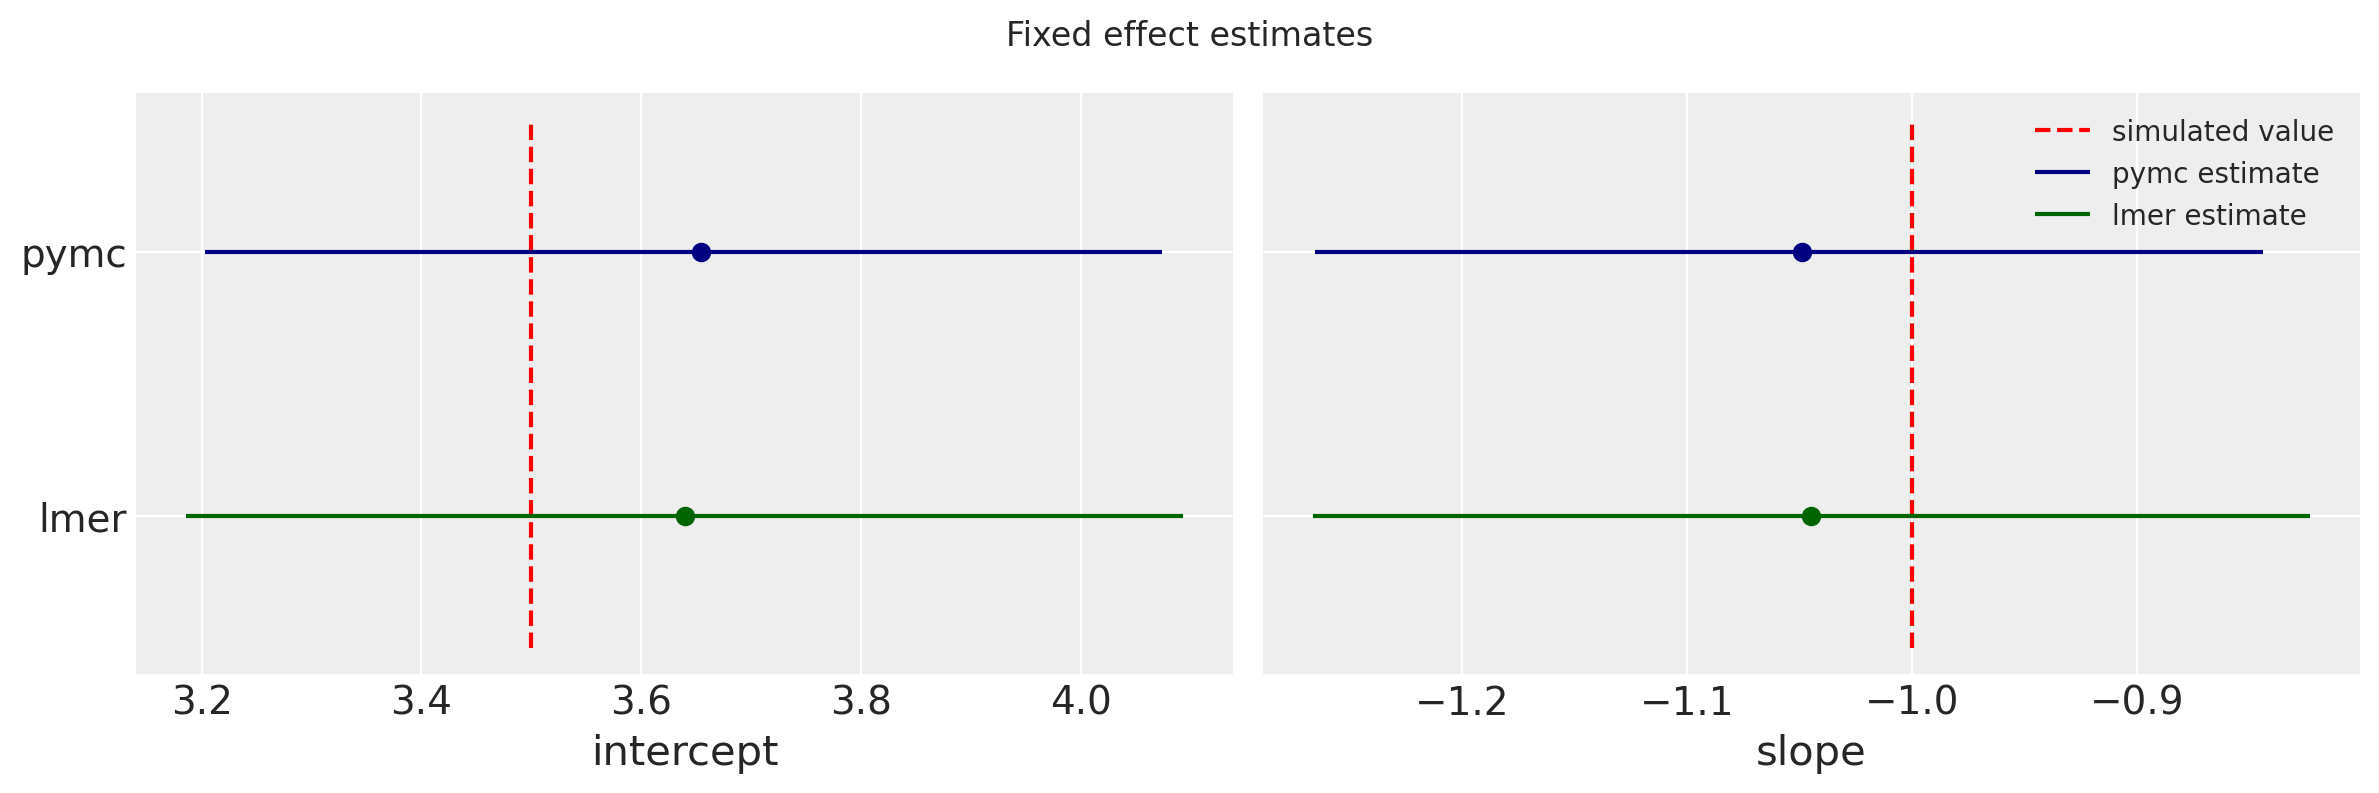

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
# value to generate data
# a, average morning wait time was defined above
ax0.vlines(x=a, ymin=0.8, ymax=1.2, linestyle='dashed', color='red')
ax1.vlines(x=b, ymin=0.8, ymax=1.2, linestyle='dashed', color='red', label='simulated value')

# pymc fixed effects value
ax0.scatter(df_summary_int_and_slope.loc['a_bar', 'mean'], 1.1, color='navy')
ax0.hlines(xmin=df_summary_int_and_slope.loc['a_bar', 'hdi_2.5%'], xmax=df_summary_int_and_slope.loc['a_bar', 'hdi_97.5%'], y=1.1, color='navy')
ax1.scatter(df_summary_int_and_slope.loc['b_bar', 'mean'], 1.1, color='navy')
ax1.hlines(xmin=df_summary_int_and_slope.loc['b_bar', 'hdi_2.5%'], xmax=df_summary_int_and_slope.loc['b_bar', 'hdi_97.5%'], y=1.1, color='navy', label='pymc estimate')

# lmer fixed effects estimate
ax0.scatter(df_fe_summary.loc['(Intercept)', 'Estimate'], 0.9, color='darkgreen')
ax0.hlines(xmin=df_fe_summary.loc['(Intercept)', 'X2.5..'], xmax=df_fe_summary.loc['(Intercept)', 'X97.5..'], y=0.9, color='darkgreen')
ax1.scatter(df_fe_summary.loc['afternoon', 'Estimate'], 0.9, color='darkgreen')
ax1.hlines(xmin=df_fe_summary.loc['afternoon', 'X2.5..'], xmax=df_fe_summary.loc['afternoon', 'X97.5..'], y=0.9, color='darkgreen', label='lmer estimate')

# plot formatting
f.suptitle('Fixed effect estimates')
ax0.set_yticks([0.9, 1.1])
ax0.set_yticklabels(['lmer', 'pymc'])

ax1.set_yticks([0.9, 1.1])
ax1.set_yticklabels(['', ''])

ax0.set(xlabel='intercept')
ax1.set(xlabel='slope')
ax1.legend(fontsize=10)
plt.tight_layout()


As promised, here is the meme that rewards you for paying attention this far!


Now to get the varying effects from  `pymc` output, we'll take each sample's intercept and slope and subtract the fixed estimate.

In [230]:
# Convert to pandas dataframe and take a glimpse at the first few rows
idata_m14_1_df = idata_m14_1.to_dataframe()
idata_m14_1_df.head()

,chain,draw,"(posterior, a_bar)","(posterior, b_bar)","(posterior, ab_subject[0,0], 0, 0)","(posterior, ab_subject[0,1], 0, 1)","(posterior, ab_subject[1,0], 1, 0)","(posterior, ab_subject[1,1], 1, 1)","(posterior, ab_subject[10,0], 10, 0)","(posterior, ab_subject[10,1], 10, 1)","(posterior, ab_subject[11,0], 11, 0)","(posterior, ab_subject[11,1], 11, 1)","(posterior, ab_subject[12,0], 12, 0)","(posterior, ab_subject[12,1], 12, 1)","(posterior, ab_subject[13,0], 13, 0)","(posterior, ab_subject[13,1], 13, 1)","(posterior, ab_subject[14,0], 14, 0)","(posterior, ab_subject[14,1], 14, 1)","(posterior, ab_subject[15,0], 15, 0)","(posterior, ab_subject[15,1], 15, 1)",...,"(log_likelihood, wait[97], 97)","(log_likelihood, wait[98], 98)","(log_likelihood, wait[99], 99)","(log_likelihood, wait[9], 9)","(sample_stats, tree_depth)","(sample_stats, max_energy_error)","(sample_stats, process_time_diff)","(sample_stats, perf_counter_diff)","(sample_stats, energy)","(sample_stats, step_size_bar)","(sample_stats, diverging)","(sample_stats, energy_error)","(sample_stats, lp)","(sample_stats, acceptance_rate)","(sample_stats, n_steps)","(sample_stats, largest_eigval)","(sample_stats, smallest_eigval)","(sample_stats, index_in_trajectory)","(sample_stats, step_size)","(sample_stats, perf_counter_start)"
0,0,0,3.397744,-0.993140,2.353823,-0.712216,3.936642,-1.328451,2.497521,-0.990675,4.589760,-1.271864,2.272038,-0.780358,3.400074,-1.307487,4.660517,-0.920542,3.967868,-1.339014,...,-0.592594,-0.280869,-1.783441,-0.404212,5,-0.452539,0.234946,0.067260,194.679539,0.246795,False,-0.226605,-167.432037,0.975607,31.0,NaN,NaN,-17,0.284311,192.355518
1,0,1,3.227032,-1.105823,2.486742,-0.657790,3.890044,-1.788579,2.894867,-0.741011,4.346072,-1.048541,2.446301,-0.678041,3.564795,-1.520221,5.013627,-1.128684,3.793134,-1.084814,...,-0.581570,-0.708670,-1.709776,-0.741664,4,0.498338,0.123327,0.033713,196.867266,0.246795,False,0.273832,-177.694232,0.809115,15.0,NaN,NaN,-8,0.284311,192.423125
2,0,2,3.393307,-0.926431,2.348434,-0.604619,3.905778,-1.355137,2.712834,-1.124770,4.409195,-1.291088,2.324233,-0.754508,3.586107,-1.562165,5.050191,-1.556993,4.122478,-1.718417,...,-0.452885,-0.109849,-2.293094,-0.559207,5,-0.382814,0.236803,0.063232,207.926089,0.246795,False,-0.347905,-176.112370,0.968229,31.0,NaN,NaN,6,0.284311,192.457135
3,0,3,3.750943,-1.109148,2.613325,-0.667234,3.682009,-1.293790,2.558511,-0.362557,4.548968,-1.266139,2.264383,-0.445725,3.102086,-0.903726,4.589499,-0.409875,4.063760,-1.249921,...,-1.239451,-0.574010,-0.906557,-1.015460,4,-0.530897,0.116930,0.037484,198.279760,0.246795,False,-0.024171,-180.489888,0.987683,15.0,NaN,NaN,-9,0.284311,192.520656
4,0,4,3.416951,-1.152993,2.478859,-0.812085,3.773041,-1.423143,2.136978,-0.465100,4.385045,-1.180823,2.160109,-0.395771,3.459758,-1.300131,5.527213,-2.107117,3.906480,-1.388326,...,-0.400278,-0.240346,-2.188396,-0.471960,5,-0.382498,0.241781,0.072736,207.993298,0.246795,False,-0.041904,-183.942618,0.999986,31.0,NaN,NaN,-24,0.284311,192.558443


In [247]:
# Get the "unbaked in" varying intercept and slope
bayesian_int = list()
bayesian_slope = list()
for i in range(20):
    idata_m14_1_df[f'varying_int_{i}'] = idata_m14_1_df[ ('posterior', f'ab_subject[{i},0]', i, 0)] - idata_m14_1_df[('posterior', 'a_bar')]
    bayesian_int.append(idata_m14_1_df[f'varying_int_{i}'].mean())

    idata_m14_1_df[f'varying_slope_{i}'] = idata_m14_1_df[ ('posterior', f'ab_subject[{i},1]', i, 1)] - idata_m14_1_df[('posterior', 'b_bar')]
    bayesian_slope.append(idata_m14_1_df[f'varying_slope_{i}'].mean())

We can now make a direct comparison between the `lmer` and `pymc` outputs. I'll ignore the uncertainties for the sake of a cleaner plot.

[Text(0.5, 0, 'lmer slope estimates'),
 Text(0, 0.5, 'pymc slope estimates'),
 Text(0.5, 1.0, 'Comparison of varying slopes')]

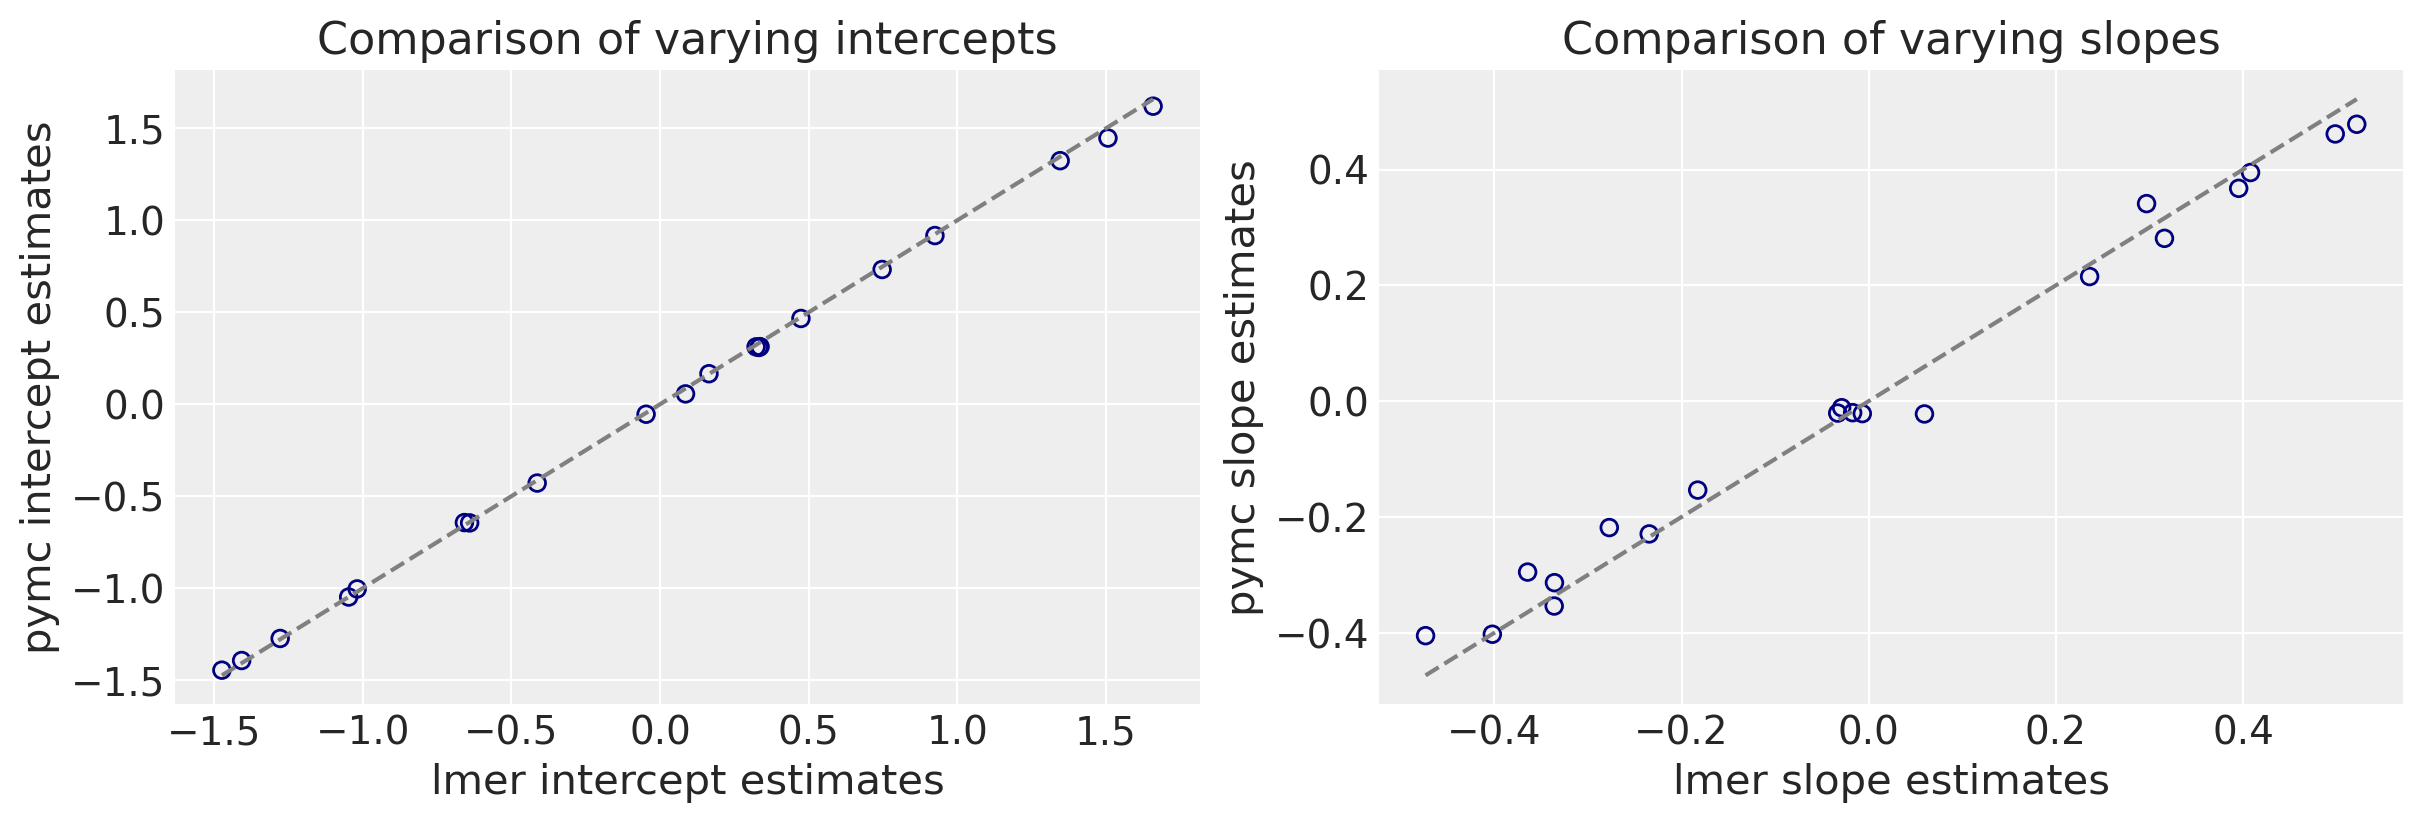

In [261]:
random_sims_int = random_sims.loc[random_sims['term']=='(Intercept)', 'mean'].copy()
random_sims_slope = random_sims.loc[random_sims['term']=='afternoon', 'mean'].copy()

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

min_max_int = [min(list(random_sims_int) + bayesian_int), max(list(random_sims_int) + bayesian_int)]
min_max_slope = [min(list(random_sims_slope) + bayesian_slope), max(list(random_sims_slope) + bayesian_slope)]

# intercepts
ax0.scatter(random_sims_int, bayesian_int, facecolors='none', edgecolors='navy')
ax0.plot(min_max_int, min_max_int, linestyle='dashed', color='gray')
ax0.set(xlabel='lmer intercept estimates', ylabel='pymc intercept estimates', title='Comparison of varying intercepts')

# slopes
ax1.scatter(random_sims_slope, bayesian_slope, facecolors='none', edgecolors='navy')
ax1.plot(min_max_slope, min_max_slope, linestyle='dashed', color='gray')
ax1.set(xlabel='lmer slope estimates', ylabel='pymc slope estimates', title='Comparison of varying slopes')

As you can see we get very similar intercepts and slopes for the cafe-specific estimates (varying effects) for the intercept and slope between the `lmer` and `pymc` approaches.

# Summary

Here in this post, I set out to compare different mixed model approaches. I looked at the equations and the programmatic implementations. I concluded by showing how the two methods can arrive at the same answer. It required a careful understanding of the differences in equations and coding language- and package-specific implementations. There were various points of writing this post that confused me but it provided opportunities for deeper understanding.

# Acknowledgements and references

Acknowledgements
- Special shoutout to Patrick Robotham (@probot) from the University of Bayes Discord channel for helping me work through *many* of my confusions.
- Eric J. Daza about some discussions about mixed effects modeling. It reminded me about improving my knowledge in this area.
- Members of the Glymour group at UCSF for checking some of my code.

References
- [UCLA introduction to linear mixed models](https://stats.oarc.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/).
- Richard McElreath's Statistical Rethinking for my introduction to Bayesian multilevel modeling and the Statistical Rethinking repo.
- Andrzej Gałecki and Tomasz Burzykowski's [Linear Mixed-Effecsts Models Using R](https://link.springer.com/book/10.1007/978-1-4614-3900-4) which references the `lme4` package. Dr. McElreath referenced this package as a non-Bayesian alternative in his book.
- Andrew Gelman wrote about why he doesn't like using "fixed and random effects" (in a [blog](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and in a [paper](https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-1/Analysis-of-variancewhy-it-is-more-important-than-ever/10.1214/009053604000001048.full)).
- TJ Mahr's [partial pooling blog post](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/).

In [262]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Sep 13 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: 2.8.2
aeppl : 0.0.35

pymc      : 4.1.7
xarray    : 2022.6.0
pandas    : 1.4.3
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:43:44) [Clang 13.0.1 ]
arviz     : 0.12.1
matplotlib: 3.5.3
aesara    : 2.8.2
numpy     : 1.23.2

Watermark: 2.3.1



In [263]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Monterey 12.5.1

Matrix products: default
LAPACK: /Users/blacar/opt/anaconda3/envs/pymc_env2/lib/libopenblasp-r0.3.21.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] merTools_0.5.2  arm_1.13-1      MASS_7.3-58.1   lme4_1.1-30    
 [5] Matrix_1.4-1    forcats_0.5.2   stringr_1.4.1   dplyr_1.0.9    
 [9] purrr_0.3.4     readr_2.1.2     tidyr_1.2.0     tibble_3.1.8   
[13] ggplot2_3.3.6   tidyverse_1.3.2

loaded via a namespace (and not attached):
 [1] httr_1.4.4          jsonlite_1.8.0      splines_4.1.3      
 [4] foreach_1.5.2       modelr_0.1.9        shiny_1.7.2        
 [7] assertthat_0.2.1    broom.mixed_0.2.9.4 googlesheets4_1.0.1
[10] cellranger_1.1.0    globals_0.16.1      pillar_1.8.1       
[13] backports_1.4.1     lattice_0.20-45     glue_1.6.2         
